**NOTE:** You probably will see warnings. These are not errors! However, you should read them and try to understand why they're there. Can you fix them?

![](http://rentinginla.com/wp-content/uploads/2015/12/Buying.jpg)
# [Project 2: Predicting House Prices with Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)

The goal of this project is for you to use EDA, visualization, data cleaning, preprocesing, and linear models to predict home prices given the features of the home, and interpret your linear models to find out what features add value to a home! This project is a bit more open-ended than project 1. 

Be sure to ...

* Think about your choices when it comes to your choices about the data. Be ready to defend your decisions!
* Use lots of plots to dig deeper into the data! Describe the plots and convey what you learned from them.
* Don't forget to read the [description of the data](../data_description.txt) (also available at the kaggle website)! This has valuable information that will help you clean and impute data. `NaN` means something in many of the columns! Don't just drop or fill them!
* Try fitting many models! Document your work and note what you've tried.
* Apply what you've learned in class, books, videos, Kaggle forums, and blog posts. There have been a TON of blog posts about this;  you should seek them out and read them!


From the Kaggle competition website:

    Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

    With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from IPython.display import display

%matplotlib inline 
np.random.seed(42)

In [2]:
import warnings
warnings.filterwarnings('ignore')

## 1. Load the Data 

* The data comes in three separate CSVs located in `../data/`. 
* Load the CSV into a `DataFrame`. 
* Make sure to check the `.head` or `.sample`. How many rows? How many columns?
* Familiarize yourself with the column names and what they represent.
* Is there a column that can be set as the `index`? If so, set that column as the index when loading the data. (`df.set_index()`)

In [3]:
train = pd.read_csv('../data/train.csv')
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
df_train = train.set_index('Id')

In [5]:
# df_train.info()

In [6]:
# df_train.shape

**Bonus:** Write an assertion statement to programmatically verify the correct number of rows and columns were imported.

## 2. Exploratory Data Analysis (EDA)

### A. Data Types

Read the data description on Kaggle. Which variables are numerical and categorical? Are there any columns that can be deleted? 

Make sure the `dtype` of each column is correct. 

**NOTE:** There is one column in particular that should be categorical but will load in pandas as numeric.

In [7]:
# #correlation matrix
# corrmat = df_num.corr()
# f, ax = plt.subplots(figsize=(15, 11))
# sns.heatmap(corrmat, vmax=.8, square=True, annot=True);

In [8]:
df_train['MSSubClass'] = df_train['MSSubClass'].astype('object')

According to the data description, MSSubClass should be categorical because the different numerical values represent different type of dwelling involved in the sale so the datatype shouldn't be int, but should be treated as str values instead





In [9]:
df_train['MSZoning'].value_counts()

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

Remove C(commercial) from MSzoning dataset since we are only trying to determine prices of homes so we only want to look at data of Residential properties. 

In [10]:
df_train = df_train[df_train.MSZoning != 'C (all)']
df_train.shape

(1450, 80)

In [11]:
df_train['Street'].value_counts()

Pave    1446
Grvl       4
Name: Street, dtype: int64

In [12]:
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending = False)
missing_data = pd.concat([total, percent], axis =1, keys = ['Total', 'Percent'])
missing_data.head(10)

,Total,Percent
PoolQC,1443,0.995172
MiscFeature,1398,0.964138
Alley,1361,0.938621
Fence,1172,0.808276
FireplaceQu,681,0.469655
LotFrontage,259,0.178621
GarageType,79,0.054483
GarageCond,79,0.054483
GarageFinish,79,0.054483
GarageQual,79,0.054483


Removed Garage Cars since the number of cars that fit into the garage would indicate the size of the Garage Area (both Garaage Cars and Garage Areas measure the size of the garage so we'd only need one of these). I'm choosing to keep Garage Area.

Remove Street since over 99% of the data are in one category (paved) and the less than 1% (4 out of 1450 data points) are extremely rare cases. Almost every home has the same category of paved street and they are varied in price; therefore, I don't believe that this feature affects homeprice. 


In [13]:
df_train = df_train.drop(['GarageCars', 'Street'], 1)

In [14]:
# df_train.info()

In [15]:
dtype = df_train.columns.to_series().groupby(df_train.dtypes).groups

In [16]:
cat_col = ['MSSubClass', 'MSZoning', 'Alley', 'LotShape', 'LandContour',
        'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
        'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
        'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond',
        'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
        'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
        'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType',
        'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC',
        'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']
df_cat = pd.DataFrame(df_train[cat_col])

In [17]:
num_col = [col for col in df_train.columns if col not in cat_col]
# numeric_cols

In [18]:
# num_col = ['LotArea', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1',
#         'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
#         'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
#         'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
#         'Fireplaces', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
#         'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'MiscVal',
#         'MoSold', 'YrSold','LotFrontage', 'MasVnrArea', 'GarageYrBlt', 'SalePrice']

In [19]:
df_num = pd.DataFrame(df_train[num_col])
print(df_cat.shape)
print(df_num.shape)
print(df_train.shape)

(1450, 43)
(1450, 35)
(1450, 78)




### B. Plot histograms of the numeric columns. 

In [20]:
# fig1 = plt.figure(1, figsize=(30,30))
# fig1.suptitle("Numeric Columns Histograms", fontsize=25)
# for i, col in enumerate(df_num.columns):
#     fig1.add_subplot(6,6,1+i)
#     plt.hist(df_num[col].dropna())
#     plt.title(col, fontsize=15)


#### What are your observations? Add them to this markdown cell.

---



### C. Plot the Numeric Columns Against `SalePrice` using scatter plots.

In [21]:
# fig = plt.figure(figsize=(40,40))
# fig.suptitle("Numeric Columns", fontsize=25)
# for i, col in enumerate(df_num.columns):
#     if 'SalePrice' not in col:
#         fig.add_subplot(6,6,1+i)
#         plt.scatter(x=col, y="SalePrice", data=df_train, s=15, alpha =0.5)
#         plt.title(col, fontsize=15)

#### What are your observations? Add them to this markdown cell.

-  Lotarea does not seem to have a linear relationship with saleprice.
-  OverallQual has a positive linear relationship with Saleprice,  higher Overallqual = higher Saleprice average.
-  YearBulit could also affect saleprice but the relationship is not clear
-  YearRemodAdd also has a flat linear relationship
-  BsmtFinSF1 cluster and could have a positive linear relationship with SalePrice --
-  TotalRmsAbovGrd could affect
-  Garage Area also affect SalePrice
-  Yr Sold does not seem to affect average price, after using box plot, can see that mean sale price does not vary much from year to year so I'm also goint to remove this column from the dataset.



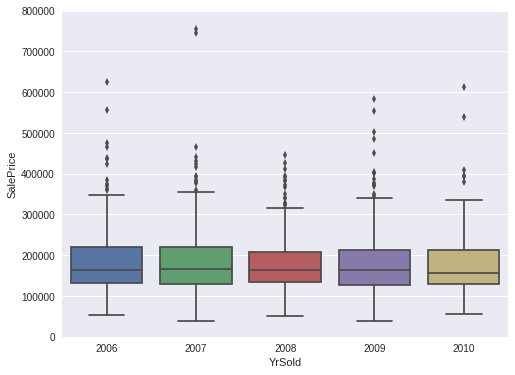

In [22]:
var = 'YrSold'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

In [23]:
df_train = df_train.drop(['YrSold'], 1)

### D. Use bar plots to plot categorical features against `SalePrice`. 

**HINT:** Look up how to create bar plots in `matplotlib`. You will have to transform the data before you can create a bar plot! Also, look up [how to plot error bars](https://pandas.pydata.org/pandas-docs/stable/visualization.html#plotting-with-error-bars) so you can also observe the variability in your data!

In [24]:
# df_train.head()
# fig = plt.figure(figsize=(40,40))
# for i, col in enumerate(df_cat):
#     fig.add_subplot(7,7,i+1)
#     fig.suptitle("Categorical Features", fontsize=25)
#     errors= df_train.groupby(df_cat.loc[:, col]).SalePrice.std()
#     df_train.groupby(df_cat.loc[:, col]).SalePrice.mean().plot.bar(alpha = 0.5, color='g',yerr=errors)

#### What are your observations? Add them to this markdown cell.

---
The mean of saleprice within each categorical column all vary from each other which means that the values could all affect sale price in different ways.

Different neighborhoods and exterior covering of the house has the most variability in the mean of sale prices which could indicate that they're important features that affect sale prices

## 3. Preprocessing

### A. Identify and Remove Outliers for `SalePrice`

Make sure to... 
* Plot a histogram of the housing price. 
* Supply a definition of what an outlier is by your criteria. Does Tukey's method make sense with 1.5 times the interquartile range, or should that range be increased or decreased?
* Use masking to remove the outliers as you've defined them.

I chose data outside of the 3rd standard deviation as outliers but the saleprice data is positively skewed where the mean is greater than the mean. So I thought that if I included up to the upper 3rd standard deviation, it would skew the mean of the sale price. 
I decided that my outliers are data points somewhere above 2 standard deviation.  When using  1.5x the interquartile range, it would be exactly on the line of 2nd stadard deviation, so I increased the k to to 2x the interquartile range to a point approxmiately inbetween 2nd and 3rd standard deviation. 

In [25]:
import scipy.stats as stats

In [26]:
low_3std= df_train['SalePrice'].mean() - 3* df_train['SalePrice'].std()
high_3std =  df_train['SalePrice'].mean() + 3*df_train['SalePrice'].std()
low_2std= df_train['SalePrice'].mean() - 2* df_train['SalePrice'].std()
high_2std =  df_train['SalePrice'].mean() + 2*df_train['SalePrice'].std()

Q1 = np.percentile(df_train['SalePrice'], q=25)
Q3 = np.percentile(df_train['SalePrice'], q=75)
k = 2
lower = Q1-3*(Q3-Q1)
upper = Q3+3*(Q3-Q1)
print(lower)
print(upper)

-122000.0
466000.0


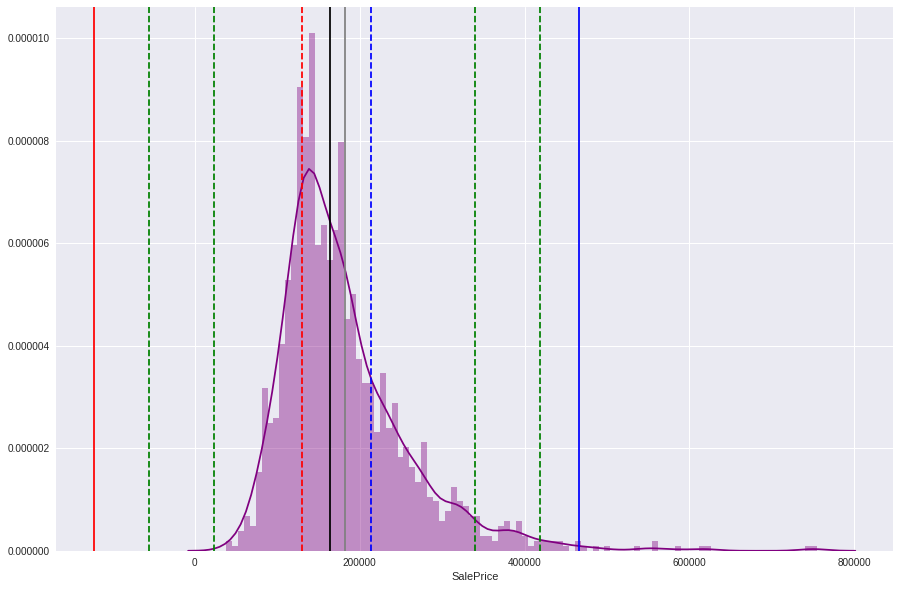

In [27]:
Q1 = np.percentile(df_train['SalePrice'], q=25)
Q3 = np.percentile(df_train['SalePrice'], q=75)
plt.figure(1, figsize=(15,10))
_ = sns.distplot(df_train['SalePrice'], bins = 100, color='purple')
plt.axvline(df_train['SalePrice'].median(), c='black')
plt.axvline(df_train['SalePrice'].mean(), c='gray')
plt.axvline(low_3std, linestyle='--', c='g')
plt.axvline(high_3std, linestyle='--', c='g')
plt.axvline(low_2std, linestyle='--', c='g')
plt.axvline(high_2std, linestyle='--', c='g')
plt.axvline(Q1, linestyle='--', c='r')
plt.axvline(Q3, linestyle='--', c='b')
plt.axvline(lower, c='r')
plt.axvline(upper, c='blue')
plt.show()

In [28]:
df2 = df_train[(df_train['SalePrice'] < upper)]
# df2.shape

In [29]:
# corrmat = df_num.corr()
# f, ax = plt.subplots(figsize=(15, 11))
# sns.heatmap(corrmat, vmax=.8, square=True, annot=True);

### B. Fill missing data!

* How many null values are in each column? Make a bar plot showing this only for columns with missing data.
* For each column with nulls, do nulls represent anything? Read the data description.
  * Some columns that are appearing as _null_ might legitimately be known (ie: "na").  Double check the [data description](../data_description.txt) for proper value representation.  A feature might actually be better represented by "not available" or "na" rather than `NULL` or `NaN`.  There's a difference between `NULL` (unknown), and "NA" (not available).  It might mean the difference between "there isn't a garage" and "there is no garage data". 
* Fill null values for each column by imputation. Here are some common methods for imputation:
  1. Using domain knowledge to select an appropriate value.
  1. Value from a randomly selected row.
  2. Mean, median, or mode value of the series.
  3. Value estimated by a predictive model.
* Make sure to justify your method for filling null values.
  

In [30]:
total = df2.isnull().sum().sort_values(ascending=False)
total= pd.DataFrame(total)

total['Col name'] = total.index
total.columns =['Nan_total', 'Col_name']
null = total[(total['Nan_total'] > 0)]

In [31]:
null

,Nan_total,Col_name
PoolQC,1432,PoolQC
MiscFeature,1386,MiscFeature
Alley,1349,Alley
Fence,1162,Fence
FireplaceQu,681,FireplaceQu
LotFrontage,258,LotFrontage
GarageType,79,GarageType
GarageQual,79,GarageQual
GarageFinish,79,GarageFinish
GarageCond,79,GarageCond


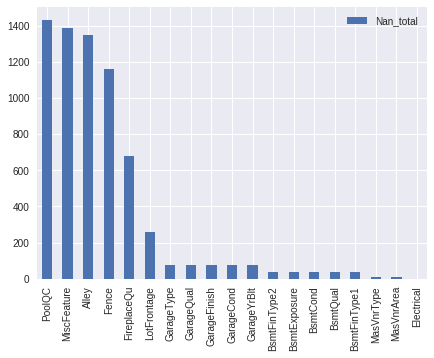

In [32]:
_ = null.plot.bar(figsize=(7,5))

- Lot Frontage: Linear feet of street: null value means missing data
- MasVnrType: Masonry veneer type, null value means missing data
- MasVnrArea: area in square feet, null means missing data
- BsmtQual: NA could be No Basement
- BsmtCont: NA could be No Basement
- BsmtExposure: NA could be No Basement
- BsmtFinType1: NA could be No Basement
- BsmtFinType2: NA could be No Basement
- BsmtFinSF1: Type 1 finished square feet, na means null
- Electrical: null value means missing data
- FirePlaceQu: NA could be No Fireplace
- GarageType: NA could be No Garage
- GarageyrBt: NA could be No Garage or null
- GarageFinish: NA could be No Garage 

In [33]:
df2['LotFrontage'] = df2.loc[:,['LotFrontage']].fillna(df2['LotFrontage'].mean())
df2['LotFrontage'].isnull().sum()

0

Replaced missing values/nan in LotFrontage with the mean. Based on the histogram, this is a normal distribution where mean=median so adding the missing values with the mean.

In [34]:
df2['MasVnrArea'] = df2.loc[:,['MasVnrArea']].fillna(df2['MasVnrArea'].median())
df2['MasVnrArea'].isnull().sum()

0

Replaced missing values/nan in MasVnrArea with the mode since the most of the data in this column is 0 and it is also the median, and there are only 7 missing values. 

In [35]:
# MsVnr_df = df2[['MasVnrType', 'MasVnrArea']]
# MsVnr_df = MsVnr_df[MsVnr_df.MasVnrType.isin([np.NaN])]
# MsVnr_df

In [36]:
df2['MasVnrType'] = df2.loc[:,['MasVnrType']].fillna('None')
df2['MasVnrType'].isnull().sum()

0

After comparing the values in columns 'MasVnrType', and 'MasVnrArea', the  dataframe shows there are 7 rows where there is 0 sf of MasMvrArea where there are Nan values.  This means that the NaN values could be 'None', as it is also the mode value of the the column 'MasVnrType.

In [37]:
df2['Electrical'].mode()

0    SBrkr
dtype: object

Replace missing values/nan in 'Electrical' with the most popular type 'SBrk' since it has the highest value count and over 90% of the data has this type. It is most likely that the null value is this type. Since there is only 1 value missing, adding this to the overall number of SBrkr also does not have a significant affect on the data

In [38]:
df2['Electrical'] = df2.loc[:,['Electrical']].fillna('SBrkr')
df2['Electrical'].isnull().sum()

0

In [39]:
df_garage = df2[['GarageArea','GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCond','GarageQual']]
df_garage = df_garage[df_garage.GarageArea.isin([0])]
# display(df_garage[df_garage['GarageType'].isnull()])

Replace all Nan values in 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual' with 'NA' which stands for No Garage. When checking these NaN values in each of these columns, it can be deduced from the GarageArae column that if the squarefootage of the garage is = 0, then GarageYrBlt, GarageFinish, and GarageQual would be NA (as in there is no garage, not there is no garage data available)

In [40]:
for col in df_garage:
    df2[col] = df2.loc[:,[col]].fillna('NA')
    print(df2[col].isnull().sum())

0
0
0
0
0
0


In [41]:
fireplaces = df2[['Fireplaces', 'FireplaceQu']]
fireplaces = fireplaces[fireplaces.Fireplaces.isin([0])]
fireplaces['FireplaceQu'].isnull().sum()
df2['FireplaceQu'] = df2.loc[:,['FireplaceQu']].fillna('NA')
df2['FireplaceQu'].isnull().sum()

0

After comparing the values in the columns Fireplaces and FireplaceQu, the fireplaces dataframe shows that there are 681 rows where there is 0 fireplace in the house sold. These are the same rows where values in FireplaceQu were shown as NaN but they should be 'NA' which means that there is no fireplace, not Null value (unknown data). 

In [42]:
df_base = df2[['BsmtFinSF1','BsmtFinSF2','BsmtFinType2', 'BsmtExposure', 'BsmtQual', 'BsmtFinType1', 'BsmtCond']]
df_base= df_base[df_base.BsmtCond.isin([np.NaN])]
# df_base

After comparing the values in  columns 'BsmtFinSF1','BsmtFinSF2','BsmtFinType2', 'BsmtExposure', 'BsmtQual', 'BsmtFinType1', 'BsmtCond', the basement dataframe shows there are 38 rows where there is 0 sf of finished basement in the same rows where there are Nan values for 'BsmtFinType2', 'BsmtExposure', 'BsmtQual', 'BsmtFinType1', 'BsmtCond'. This means that the NaN values should be 'NA/No basement' because there is no basement in these houses since the sq of the basement is 0. So I replace the Null values with 'NA'. 

In [43]:
for col in df_base:
    df2[col] = df2.loc[:,[col]].fillna('NA')
    print(df2[col].isnull().sum())

0
0
0
0
0
0
0


In [44]:
df_NA = df2[['PoolQC','MiscFeature','Alley', 'Fence']]
for col in df_NA:
    df2[col] = df2.loc[:,[col]].fillna('NA')
    print(df2[col].isnull().sum())

0
0
0
0


Verify that you have *truly* eliminated all the null values!

In [45]:
# df2.isnull().sum().sort_values(ascending=False)

### C. Create dummy variables for categorical columns

Use `pd.get_dummies()` to turn your categorical features into numeric features. Make sure there are **no null values** in your dataset before you do this!

In [46]:
df_dummies = pd.get_dummies(df2)
df_dummies.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1,65.0,8450,7,5,2003,2003,196.0,706,0,150,...,0,0,0,1,0,0,0,0,1,0
2,80.0,9600,6,8,1976,1976,0.0,978,0,284,...,0,0,0,1,0,0,0,0,1,0
3,68.0,11250,7,5,2001,2002,162.0,486,0,434,...,0,0,0,1,0,0,0,0,1,0
4,60.0,9550,7,5,1915,1970,0.0,216,0,540,...,0,0,0,1,1,0,0,0,0,0
5,84.0,14260,8,5,2000,2000,350.0,655,0,490,...,0,0,0,1,0,0,0,0,1,0


In [47]:
df_dummies= df_dummies.drop(['SalePrice'], axis=1)

### D. Split your data into a train and test set.

* Use `train_test_split` to hold out a test set. 
* Why do we hold out a test set?

In [48]:
from sklearn.model_selection import train_test_split

In [49]:
seed = 42
target = df2['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(df_dummies,
                                                    target,
                                                    train_size = .8,
                                                    random_state = seed)


We hold out a test set because we need to understand how our model performs on data it hasn't seen. We may create a model that fits our training data very well but does not score well on the test set, suggesting that it won't predict well given new data. With a test set, we can understand how our model performs on unseen data.

### E. Scale the data

Make sure to...
* instantiate a `StandardScaler` object
* `fit` the scaler on your training data
* `transform` both your training and test data.

In [50]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 4. Modeling

Now that you've completed your EDA, you can now use your training data to build a model to predict home price from your features! As far as regression methods, you've learned a few, including ordinary least squares (a.k.a. `LinearRegression`), `Lasso`, `Ridge`, and `ElasticNet`. 

### A. Benchmarking

As we get started with modeling we should have some basis for comparison to get a sense of what a "good" model is for this task. 

For this task, as we will be focusing on linear models, we will use the most naive of the linear models, the Linear Regression as our benchmark. 

In [51]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, SGDRegressor


lr = LinearRegression()

lr.fit(X_train_scaled, y_train)

print(lr.score(X_train_scaled, y_train))
print(lr.score(X_test_scaled, y_test))

0.946091183617
-7.32733001493e+23


#### Results Dictionary

Make a results `list` to hold your results. After each model fit and score, you will add a dictionary of your results to this list using `.append()`. This will give you a list of dictionaries ... perfect for a DataFrame!

This is the pattern you will be using:

In [52]:
results = list()

In [53]:
# example_results = results()
# result_1 = {'name':'test1','dataset' : 'train','preprocessing': 'raw','score': '10 bajillion'}
# example_results.append(result_1)
# result_2 = {'name':'test1','dataset' : 'train','preprocessing': 'scaled','score': '20 bajillion'}
# example_results.append(result_2)

Then we pass the results list to pass to a DataFrame.

In [54]:
# pd.DataFrame(example_results)

This gives us a convenient tool for manipulating our results and tracking our work ... our old friend, Pandas!

#### Make a new results list.

In [55]:
results = list()

#### Raw Benchmark

Instantiate a new `LinearRegression` model and save it as `benchmark_raw`.

In [56]:
benchmark_raw = LinearRegression()

In [57]:
benchmark_scaled = LinearRegression()

- Fit the `benchmark_raw` model against the raw training data. 
- Score the `benchmark_raw` model against both the raw training set and the raw testing set. 
- Apprend a results dictionary to the `results` list. 

You could do this by

    results.append({'name':'benchmark',
                    'model': benchmark_raw,
                    'dataset' : 'train',
                    'preprocessing': 'raw',
                    'score': raw_train_score})
                    
Of course you can store a model in a dictionary!                    

In [58]:
benchmark_raw.fit(X_train, y_train)
raw_train_score = benchmark_raw.score(X_train, y_train)
raw_test_score = benchmark_raw.score(X_test, y_test)

results.append({'name':'benchmark',
                'model':benchmark_raw,
                'dataset' : 'train',
                'preprocessing': 'raw',
                'score': raw_train_score})
results.append({'name':'benchmark',
                'model':benchmark_raw,
                'dataset' : 'test',
                'preprocessing': 'raw',
                'score': raw_test_score})

In [59]:
benchmark_scaled.fit(X_train_scaled, y_train)
scaled_train_score = benchmark_scaled.score(X_train_scaled, y_train)
scaled_test_score = benchmark_scaled.score(X_test_scaled, y_test)

results.append({'name':'benchmark',
                'model':benchmark_scaled,
                'dataset' : 'train_scaled',
                'preprocessing': 'scaled',
                'score': scaled_train_score})
results.append({'name':'benchmark',
                'model':benchmark_scaled,
                'dataset' : 'test_scaled',
                'preprocessing': 'scaled',
                'score': scaled_test_score})

#### Scaled Benchmark

- Fit the `benchmark_scaled` model against the scaled training data. 
- Score the `benchmark_scaled` model against both the scaled training set and the scaled testing set. 
- Write the results to the results `list`. 

In [60]:
results

[{'dataset': 'train',
  'model': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
  'name': 'benchmark',
  'preprocessing': 'raw',
  'score': 0.94634669328231491},
 {'dataset': 'test',
  'model': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
  'name': 'benchmark',
  'preprocessing': 'raw',
  'score': -583059360.49338973},
 {'dataset': 'train_scaled',
  'model': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
  'name': 'benchmark',
  'preprocessing': 'scaled',
  'score': 0.94609118361653211},
 {'dataset': 'test_scaled',
  'model': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
  'name': 'benchmark',
  'preprocessing': 'scaled',
  'score': -7.3273300149254404e+23}]

Use a DataFrame to display your results.

In [61]:
pd.DataFrame(results)

,dataset,model,name,preprocessing,score
0,train,"LinearRegression(copy_X=True, fit_intercept=Tr...",benchmark,raw,9.463467e-01
1,test,"LinearRegression(copy_X=True, fit_intercept=Tr...",benchmark,raw,-5.830594e+08
2,train_scaled,"LinearRegression(copy_X=True, fit_intercept=Tr...",benchmark,scaled,9.460912e-01
3,test_scaled,"LinearRegression(copy_X=True, fit_intercept=Tr...",benchmark,scaled,-7.327330e+23


#### What are your observations? Add them to this markdown cell.

The training score looks pretty good for both raw and scaled data but it's a lot worse on the test data which means this model is not the best model for this data set
---


### B. Naive Regularization

Next, prepare a series of fits using the three regularized linear regression models with their default settings.

Perform each of these against both the raw and the scaled data. In this section, you should be fitting six models.

- A naive Ridge Regression against the raw data
- A naive Lasso Regression against the raw data
- A naive ElasticNet Regression against the raw data
- A naive Ridge Regression against the scaled data
- A naive Lasso Regression against the scaled data
- A naive ElasticNet Regression against the scaled data

**NOTE:** By "naive" we mean using all of the default settings.

In [62]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet

In [63]:
Ridge_raw = Ridge()
Ridge_scaled = Ridge()
Lasso_raw = Lasso()
Lasso_scaled = Lasso()
Elastic_raw = ElasticNet()
Elastic_scaled = ElasticNet()

In [64]:
Ridge_raw.fit(X_train, y_train)
raw_train_score = Ridge_raw.score(X_train, y_train)
raw_test_score = Ridge_raw.score(X_test, y_test)

results.append({'name':'Ridge',
                'model':Ridge_raw,
                'dataset' : 'train',
                'preprocessing': 'raw',
                'score': raw_train_score})
results.append({'name':'Ridge',
                'model':Ridge_raw,
                'dataset' : 'test',
                'preprocessing': 'raw',
                'score': raw_test_score})

Ridge_scaled.fit(X_train_scaled, y_train)
scaled_train_score = Ridge_scaled.score(X_train_scaled, y_train)
scaled_test_score = Ridge_scaled.score(X_test_scaled, y_test)

results.append({'name':'Ridge',
                'model':Ridge_scaled,
                'dataset' : 'train_scaled',
                'preprocessing': 'scaled',
                'score': scaled_train_score})
results.append({'name':'Ridge',
                'model':Ridge_scaled,
                'dataset' : 'test_scaled',
                'preprocessing': 'scaled',
                'score': scaled_test_score})

In [65]:
Lasso_raw.fit(X_train, y_train)
raw_train_score = Lasso_raw.score(X_train, y_train)
raw_test_score = Lasso_raw.score(X_test, y_test)

results.append({'name':'Lasso',
                'model':Lasso_raw,
                'dataset' : 'train',
                'preprocessing': 'raw',
                'score': raw_train_score})
results.append({'name':'Lasso',
                'model':Lasso_raw,
                'dataset' : 'test',
                'preprocessing': 'raw',
                'score': raw_test_score})

Lasso_scaled.fit(X_train_scaled, y_train)
scaled_train_score = Lasso_scaled.score(X_train_scaled, y_train)
scaled_test_score = Lasso_scaled.score(X_test_scaled, y_test)

results.append({'name':'Lasso',
                'model':Lasso_scaled,
                'dataset' : 'train_scaled',
                'preprocessing': 'scaled',
                'score': scaled_train_score})
results.append({'name':'Lasso',
                'model':Lasso_scaled,
                'dataset' : 'test_scaled',
                'preprocessing': 'scaled',
                'score': scaled_test_score})

In [66]:
Elastic_raw.fit(X_train, y_train)
raw_train_score = Elastic_raw.score(X_train, y_train)
raw_test_score = Elastic_raw.score(X_test, y_test)

results.append({'name':'Elastic',
                'model':Elastic_raw,
                'dataset' : 'train',
                'preprocessing': 'raw',
                'score': raw_train_score})
results.append({'name':'Elastic',
                'model':Elastic_raw,
                'dataset' : 'test',
                'preprocessing': 'raw',
                'score': raw_test_score})

Elastic_scaled.fit(X_train_scaled, y_train)
scaled_train_score = Elastic_scaled.score(X_train_scaled, y_train)
scaled_test_score = Elastic_scaled.score(X_test_scaled, y_test)

results.append({'name':'Elastic',
                'model':Elastic_scaled,
                'dataset' : 'train_scaled',
                'preprocessing': 'scaled',
                'score': scaled_train_score})
results.append({'name':'Elastic',
                'model':Elastic_scaled,
                'dataset' : 'test_scaled',
                'preprocessing': 'scaled',
                'score': scaled_test_score})

Note that we see warnings here. As we are in an exploration phase with our model, this is acceptable.

Use a DataFrame to store your `results` as `results_df`. By this we mean, save the `results` list into a new dataframe so that you can manipulate the DataFrame.

In [67]:
results_df = pd.DataFrame(results)
results_df

,dataset,model,name,preprocessing,score
0,train,"LinearRegression(copy_X=True, fit_intercept=Tr...",benchmark,raw,9.463467e-01
1,test,"LinearRegression(copy_X=True, fit_intercept=Tr...",benchmark,raw,-5.830594e+08
2,train_scaled,"LinearRegression(copy_X=True, fit_intercept=Tr...",benchmark,scaled,9.460912e-01
3,test_scaled,"LinearRegression(copy_X=True, fit_intercept=Tr...",benchmark,scaled,-7.327330e+23
4,train,"Ridge(alpha=1.0, copy_X=True, fit_intercept=Tr...",Ridge,raw,9.332452e-01
5,test,"Ridge(alpha=1.0, copy_X=True, fit_intercept=Tr...",Ridge,raw,8.714617e-01
6,train_scaled,"Ridge(alpha=1.0, copy_X=True, fit_intercept=Tr...",Ridge,scaled,9.463303e-01
7,test_scaled,"Ridge(alpha=1.0, copy_X=True, fit_intercept=Tr...",Ridge,scaled,8.659373e-01
8,train,"Lasso(alpha=1.0, copy_X=True, fit_intercept=Tr...",Lasso,raw,9.462867e-01
9,test,"Lasso(alpha=1.0, copy_X=True, fit_intercept=Tr...",Lasso,raw,8.728509e-01


#### Display just the raw test results using pandas

You can do this using pandas indexing as follows

    results_df[(results_df.preprocessing == 'raw') & 
               (results_df.dataset == 'test')]

In [68]:
results_df[(results_df.preprocessing == 'raw') & 
           (results_df.dataset == 'test')]

,dataset,model,name,preprocessing,score
1,test,"LinearRegression(copy_X=True, fit_intercept=Tr...",benchmark,raw,-5.830594e+08
5,test,"Ridge(alpha=1.0, copy_X=True, fit_intercept=Tr...",Ridge,raw,8.714617e-01
9,test,"Lasso(alpha=1.0, copy_X=True, fit_intercept=Tr...",Lasso,raw,8.728509e-01
13,test,"ElasticNet(alpha=1.0, copy_X=True, fit_interce...",Elastic,raw,8.530942e-01


#### What are your observations? Add them to this markdown cell.

---
The bechmark score of Linear Regession model is much worse than the Ridge, Lasso and Elastic model


#### Display just the scaled test results

In [69]:
results_df[(results_df.preprocessing == 'scaled') & 
           (results_df.dataset == 'test_scaled')]

,dataset,model,name,preprocessing,score
3,test_scaled,"LinearRegression(copy_X=True, fit_intercept=Tr...",benchmark,scaled,-7.327330e+23
7,test_scaled,"Ridge(alpha=1.0, copy_X=True, fit_intercept=Tr...",Ridge,scaled,8.659373e-01
11,test_scaled,"Lasso(alpha=1.0, copy_X=True, fit_intercept=Tr...",Lasso,scaled,8.478787e-01
15,test_scaled,"ElasticNet(alpha=1.0, copy_X=True, fit_interce...",Elastic,scaled,8.843902e-01


#### What are your observations? Add them to this markdown cell.

---



These are your benchmark results. You will refer to these for analysis during the next phase.

#### Display just the Benchmark models

In [70]:
results_df[(results_df.name == 'benchmark')]

,dataset,model,name,preprocessing,score
0,train,"LinearRegression(copy_X=True, fit_intercept=Tr...",benchmark,raw,9.463467e-01
1,test,"LinearRegression(copy_X=True, fit_intercept=Tr...",benchmark,raw,-5.830594e+08
2,train_scaled,"LinearRegression(copy_X=True, fit_intercept=Tr...",benchmark,scaled,9.460912e-01
3,test_scaled,"LinearRegression(copy_X=True, fit_intercept=Tr...",benchmark,scaled,-7.327330e+23


#### Display just the Ridge models

In [71]:
results_df[(results_df.name == 'Ridge')]

,dataset,model,name,preprocessing,score
4,train,"Ridge(alpha=1.0, copy_X=True, fit_intercept=Tr...",Ridge,raw,0.933245
5,test,"Ridge(alpha=1.0, copy_X=True, fit_intercept=Tr...",Ridge,raw,0.871462
6,train_scaled,"Ridge(alpha=1.0, copy_X=True, fit_intercept=Tr...",Ridge,scaled,0.946330
7,test_scaled,"Ridge(alpha=1.0, copy_X=True, fit_intercept=Tr...",Ridge,scaled,0.865937


#### Display just the Lasso models

In [72]:
results_df[(results_df.name == 'Lasso')]

,dataset,model,name,preprocessing,score
8,train,"Lasso(alpha=1.0, copy_X=True, fit_intercept=Tr...",Lasso,raw,0.946287
9,test,"Lasso(alpha=1.0, copy_X=True, fit_intercept=Tr...",Lasso,raw,0.872851
10,train_scaled,"Lasso(alpha=1.0, copy_X=True, fit_intercept=Tr...",Lasso,scaled,0.946346
11,test_scaled,"Lasso(alpha=1.0, copy_X=True, fit_intercept=Tr...",Lasso,scaled,0.847879


#### Display just the Elasticnet models

In [73]:
results_df[(results_df.name == 'Elastic')]

,dataset,model,name,preprocessing,score
12,train,"ElasticNet(alpha=1.0, copy_X=True, fit_interce...",Elastic,raw,0.835612
13,test,"ElasticNet(alpha=1.0, copy_X=True, fit_interce...",Elastic,raw,0.853094
14,train_scaled,"ElasticNet(alpha=1.0, copy_X=True, fit_interce...",Elastic,scaled,0.920571
15,test_scaled,"ElasticNet(alpha=1.0, copy_X=True, fit_interce...",Elastic,scaled,0.884390


#### What are your observations? Add them to this markdown cell.

---



### C. Cross-validated models

Import the Cross-Validation Models for each of the Regularized Linear Models

In [74]:
cv_results = list()

In [75]:
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV

Perform the cross-validation using an `np.logspace(-2,4,7)`.

In [76]:
def score_CV_raw(name, model):
    alphas = np.logspace(-2,4,7)
    name = model(alphas=alphas, cv=5)
    name.fit(X_train, y_train)
    name_raw_score = name.score(X_train, y_train)
    name_test_score =name.score(X_test, y_test)
    cv_results = []
    cv_results.append({'name':'name',
                    'name':name,
                    'dataset' : 'train',
                    'preprocessing': 'raw',
                    'score': raw_train_score})
    cv_results.append({'name':'name',
                    'name':name,
                    'dataset' : 'test',
                    'preprocessing': 'raw',
                    'score': raw_test_score})
    return cv_results

In [77]:
def score_CV_scaled(name, model):
  
    alphas = np.logspace(-2,4,7)
    name = model(alphas=alphas, cv=5)
    name.fit(X_train_scaled, y_train)
    name_raw_score = name.score(X_train_scaled, y_train)
    name_test_score =name.score(X_test_scaled, y_test)
    cv_results = []
    cv_results.append({'name':'name',
                    'name':name,
                    'dataset' : 'train',
                    'preprocessing': 'scaled',
                    'score': scaled_train_score})
    cv_results.append({'name':'name',
                    'name':name,
                    'dataset' : 'test',
                    'preprocessing': 'scaled',
                    'score': scaled_test_score})
    return cv_results

In [78]:

import warnings
warnings.filterwarnings('ignore')

In [79]:
Ridge_CV_scaled = pd.DataFrame(score_CV_scaled(Ridge, RidgeCV))
Ridge_CV_raw = pd.DataFrame(score_CV_raw(Ridge, RidgeCV))
Lasso_CV_raw = pd.DataFrame(score_CV_raw(Lasso, LassoCV))
Lasso_CV_scaled = pd.DataFrame(score_CV_scaled(Lasso, LassoCV))
Elastic_CV_raw = pd.DataFrame(score_CV_raw(ElasticNet, ElasticNetCV))
Elastic_CV_scaled = pd.DataFrame(score_CV_scaled(ElasticNet, ElasticNetCV))


In [80]:
df_CV = pd.concat([Ridge_CV_raw, Ridge_CV_scaled, Lasso_CV_raw, Lasso_CV_scaled, Elastic_CV_raw, Elastic_CV_scaled], ignore_index=True)
df_CV

,dataset,name,preprocessing,score
0,train,"RidgeCV(alphas=array([ 1.00000e-02, 1.00000...",raw,0.835612
1,test,"RidgeCV(alphas=array([ 1.00000e-02, 1.00000...",raw,0.853094
2,train,"RidgeCV(alphas=array([ 1.00000e-02, 1.00000...",scaled,0.920571
3,test,"RidgeCV(alphas=array([ 1.00000e-02, 1.00000...",scaled,0.884390
4,train,"LassoCV(alphas=array([ 1.00000e-02, 1.00000...",raw,0.835612
5,test,"LassoCV(alphas=array([ 1.00000e-02, 1.00000...",raw,0.853094
6,train,"LassoCV(alphas=array([ 1.00000e-02, 1.00000...",scaled,0.920571
7,test,"LassoCV(alphas=array([ 1.00000e-02, 1.00000...",scaled,0.884390
8,train,"ElasticNetCV(alphas=array([ 1.00000e-02, 1....",raw,0.835612
9,test,"ElasticNetCV(alphas=array([ 1.00000e-02, 1....",raw,0.853094


#### Display just the raw test results

In [81]:
df_CV[(df_CV.preprocessing == 'raw') & 
           (df_CV.dataset == 'test')]

,dataset,name,preprocessing,score
1,test,"RidgeCV(alphas=array([ 1.00000e-02, 1.00000...",raw,0.853094
5,test,"LassoCV(alphas=array([ 1.00000e-02, 1.00000...",raw,0.853094
9,test,"ElasticNetCV(alphas=array([ 1.00000e-02, 1....",raw,0.853094


#### Display just the scaled test results

In [82]:
df_CV[(df_CV.preprocessing == 'scaled') & (df_CV.dataset == 'test') ]

,dataset,name,preprocessing,score
3,test,"RidgeCV(alphas=array([ 1.00000e-02, 1.00000...",scaled,0.88439
7,test,"LassoCV(alphas=array([ 1.00000e-02, 1.00000...",scaled,0.88439
11,test,"ElasticNetCV(alphas=array([ 1.00000e-02, 1....",scaled,0.88439


### D. Model Selection

Interpret Regression Metrics for each of your models. Choose one of the following:

* R2
* MSE / RMSE
* MAE

What are your top 3 performing models? 

In [83]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

## Explain the bias / variance tradeoff

Why do regularized models perform better on your test set?

### Interpreting coefficients

For your best model, 

* plot relevant coefficients using the `plot_coef` functoin.


In [84]:
def plot_coef(model, top_n = 10):
    '''
    Plots the magnitude of top and bottom n coefficients
    '''
    cols = X_train.columns
    coef = model.coef_
    zipped = list(zip(cols, coef))
    zipped.sort(key=lambda x: x[1], reverse = True)
    top_10 = pd.DataFrame(zipped).head(top_n)
    bottom_10 = pd.DataFrame(zipped).tail(top_n)
    return pd.concat([top_10, bottom_10], axis=0).plot.barh(x = 0, y = 1)

#### Plot your coefficients.

In [90]:
Ridge.

AttributeError: type object 'Ridge' has no attribute 'coef_'

In [86]:
ridge = Ridge()
lasso = Lasso()
elastic = Lasso()

In [88]:
plot_coef(lasso)

TypeError: zip argument #2 must support iteration

In [ ]:
plot_coef(ridge, top_n=10)

In [ ]:
plot_coef(Elastic, top_n=10)

#### Which features add / take away most value from a home?

# (Optional) Informing Business Value

Interpreting our work for a non-technical audience is a vital skill that every good Data Scientist must cultivate.  At the end of the day, our work must be informative to business process so connecting our detailed efforts to a high level strategy is critical.

We've established a few businesses cases that you should assert some explanation and advise best strategy through a model of your choice.  Also call out any exploratory analysis and reasoning for any recommendation.

##### For each question:
* Plot relevant data
* Fit a new model or use a previous  model
* Plot relevant coefficients


#### (Optional) Case 1: Which features add / take away most value from a home?

You just explained which coeffients add / take away most value, technically, but can you explain this in a non-technical manner?  Also, emphasize _why_ in your explanation.

- Choose a few examples and explain why the coefficients describe the target value of the property.

#### (Optional) Case 2: Can you identify any abnormally priced houses?
We might consider these being properties that are over or under predicted by price. Can you make sense of when and why these are over and under predicted?

#### (Optional) Case 3:  Which houses are good investments?

Which criteria would you look at?  How sure can you be of your assumptions?  Give precise metrics but also give a concise recommendation that is non-technical that communicates the risks of your anlaysis.

#### (Optional) Case 4:  Which houses are good investments (extended)?
One idea that is common in the real-estate invement community is called "flipping".  This usually entails buying a property with "changable" charactaristics that can be upgraded.  Examples of changable or "upgradable" features include:  A garage, a kitchen, etc.

Can you give us an idea of investments opportunities considering "upgradable" features?  You will have to explore this idea on your own and possibly do a little research for subject matter expertise.

- Some features of a house are worth more than others
- Some features can't be upgraded (ie: square footage)